In [1]:
# import matplotlib.pyplot as plt 

# import scipy.ndimage.filters
# import scipy.stats

# from skimage.transform import pyramid_laplacian

# from PIL import Image
# from PIL import ImageFilter

# import numpy as np

import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage
%matplotlib inline

(750, 1000, 3) (750, 1000, 3) (750, 1000, 3)


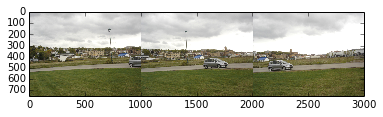

In [11]:
one = np.asarray(Image.open("Images/Q2/Working set/I1.jpg"),dtype=np.float64)/255.0
two = np.asarray(Image.open("Images/Q2/Working set/I2.jpg"),dtype=np.float64)/255.0
three = np.asarray(Image.open("Images/Q2/Working set/I3.jpg"),dtype=np.float64)/255.0

print one.shape, two.shape, three.shape

# combining images
ipan = np.concatenate((one, two, three), axis =1)

plt.figure()
plt.imshow(ipan)
# plt.figure()
# plt.imshow(two)
# plt.figure()
# plt.imshow(three)
# plt.figure()

In [14]:
import sift

sift.process_image('basmati.pgm', 'basmati.key')
l1,d1 = sift.read_features_from_file('basmati.key')
im = array(Image.open('basmati.pgm'))
sift.plot_features(im,l1)

processed basmati.pgm


IOError: [Errno 2] No such file or directory: 'basmati.key'